Text(0.5, 1.0, 'Image 1')

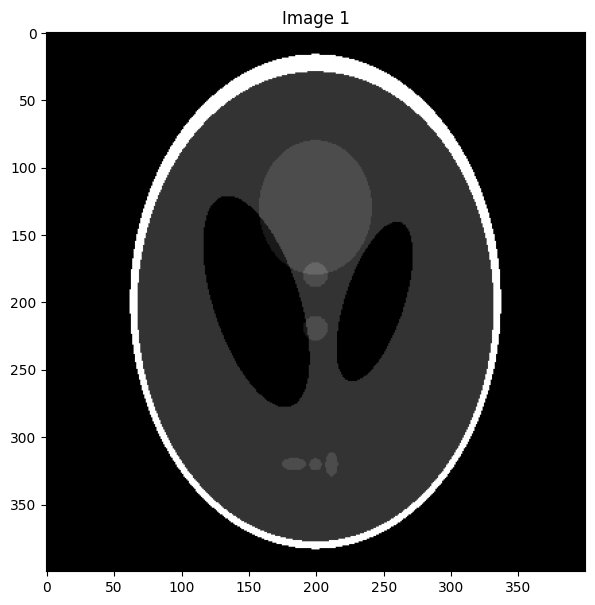

In [1]:
import torch
from QBI_radon import Radon

# import libraries
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon
plt.rcParams["figure.figsize"] = [7, 7]
import numpy as np
import time

img = shepp_logan_phantom()

# define some constants
batch_size = 1
n_angles = 512

# imshow img1 and img2
plt.figure()
plt.imshow(img,cmap='gray')
plt.title('Image 1')


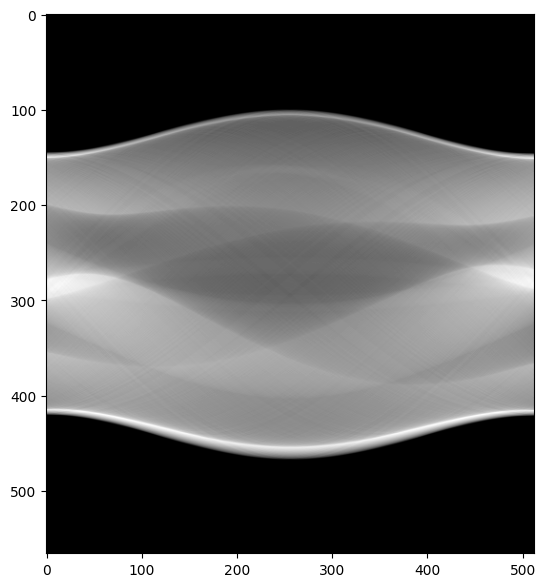

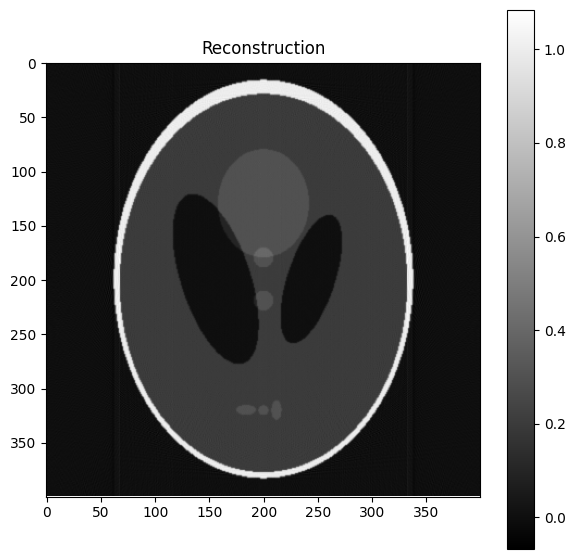

In [2]:
sinogram = radon(img, theta=np.linspace(0, 180, n_angles), circle=False)
plt.imshow(sinogram, cmap="gray")
plt.show()
reconstructed_skimage = iradon(sinogram, theta=np.linspace(0, 180, n_angles), filter_name="ramp", circle=False)
plt.imshow(reconstructed_skimage, cmap='gray')
plt.colorbar()
plt.title("Reconstruction")
plt.show()

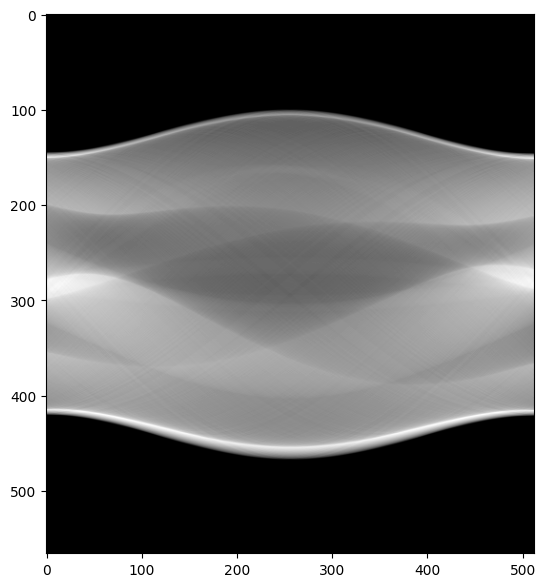

In [9]:
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon
plt.rcParams["figure.figsize"] = [7, 7]
import numpy as np
import time

img = shepp_logan_phantom()
n_angles = 512
sinogram = radon(img, theta=np.linspace(0, 180, n_angles), circle=False)
plt.imshow(sinogram, cmap="gray")
plt.show()
#

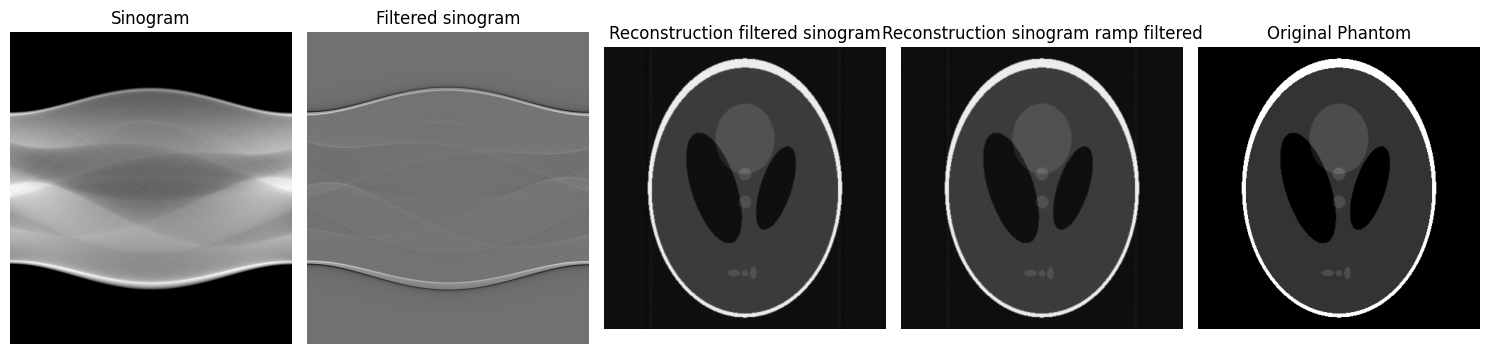

fbb error filtered sinogram:  0.13157035039283793
fbb error ramp filtered sinogram:  0.12471816021283742


In [3]:

# --- Apply Ramp Filter ---
def ramp_filter(sinogram):
    num_detectors, num_angles = sinogram.shape
    n = int(2 ** np.ceil(np.log2(num_detectors)))  # zero-padding for FFT
    freqs = np.fft.fftfreq(n).reshape(-1, 1)
    ramp = 2 * np.abs(freqs)

    filtered_sino = np.zeros_like(sinogram)

    for i in range(num_angles):
        projection = sinogram[:, i]
        padded = np.zeros(n)
        padded[:num_detectors] = projection

        proj_fft = np.fft.fft(padded)
        filtered_fft = proj_fft * ramp[:, 0]
        filtered_proj = np.real(np.fft.ifft(filtered_fft))[:num_detectors]

        filtered_sino[:, i] = filtered_proj

    return filtered_sino

# Apply the filter
filtered_sinogram = ramp_filter(sinogram)


recon_filtered = iradon(filtered_sinogram, theta=np.linspace(0, 180, n_angles), circle=False, filter_name=None)
recon_filtered_skimage = iradon(sinogram, theta=np.linspace(0, 180, n_angles), circle=False, filter_name="ramp")
# --- Plot ---
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# show sinogram
axes[0].imshow(sinogram, cmap='gray')
axes[0].set_title('Sinogram')
axes[0].axis('off')
# show filtered_sinogram
axes[1].imshow(filtered_sinogram, cmap='gray')
axes[1].set_title('Filtered sinogram')
axes[1].axis('off')
#show recon_filtered
axes[2].imshow(recon_filtered, cmap='gray')
axes[2].set_title('Reconstruction filtered sinogram')
axes[2].axis('off')
#show recon_filtered_skimage
axes[3].imshow(recon_filtered_skimage, cmap='gray')
axes[3].set_title('Reconstruction sinogram ramp filtered')
axes[3].axis('off')
# show img
axes[4].imshow(img, cmap='gray')
axes[4].set_title('Original Phantom')
axes[4].axis('off')
plt.tight_layout()
plt.show()
print("fbb error filtered sinogram: ", np.linalg.norm(img - recon_filtered) / np.linalg.norm(img))
print("fbb error ramp filtered sinogram: ", np.linalg.norm(img - recon_filtered_skimage) / np.linalg.norm(img))


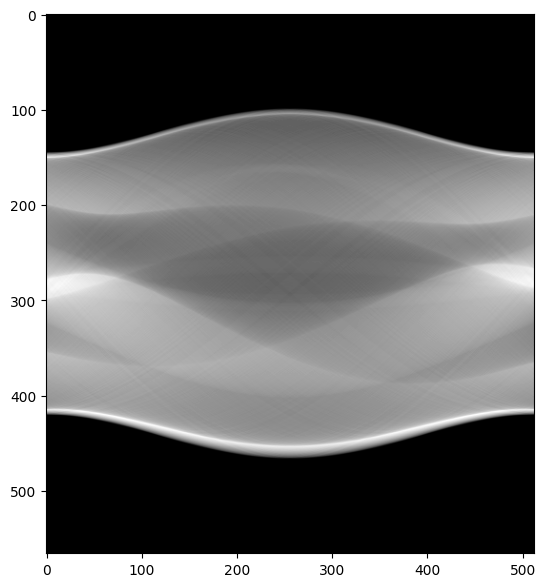

In [4]:
from torch_radon24 import Radon, fourier_filter
device = torch.device("cuda")

image = torch.FloatTensor(img).to(device)[None, None]

radon_op = Radon(thetas=np.linspace(0, np.pi, n_angles), circle=False, device=device, filter_name="ramp")
sinogram = radon_op.forward(image)
plt.imshow(sinogram.cpu().numpy()[0, 0], cmap="gray")

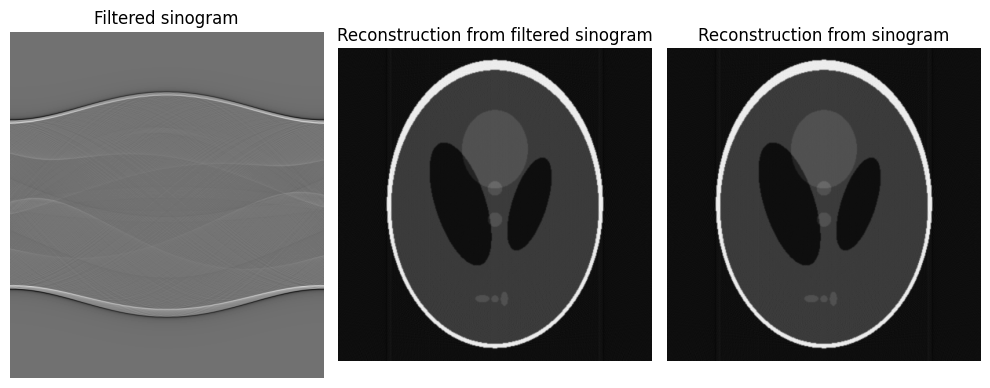

fbb error filtered sinogram:  0.13140862533199407
fbb error sinogram:  0.1245302240853769


In [5]:
def ramp_filter_torch(sinogram, device="cpu"):
    """
    Apply ramp filter to a batched sinogram tensor: [B, 1, D, A]
    Returns: filtered sinogram of same shape
    """
    B, C, D, A = sinogram.shape
    n = int(2 ** torch.ceil(torch.log2(torch.tensor(D, dtype=torch.float32))))  # padded size
    freqs = torch.fft.fftfreq(n, device=device).abs()  # [n]
    ramp = 2 * freqs  # [n]

    # Pad detector axis (dim=2)
    pad_size = n - D
    sino_padded = torch.nn.functional.pad(sinogram, (0, 0, 0, pad_size))  # [B, 1, n, A]

    # FFT along detector axis
    sino_fft = torch.fft.fft(sino_padded, dim=2)

    # Apply ramp filter
    ramp = ramp.view(1, 1, -1, 1)  # reshape for broadcasting
    filtered_fft = sino_fft * ramp.to(sinogram.device)

    # Inverse FFT and crop back to original detector size
    filtered_sino = torch.real(torch.fft.ifft(filtered_fft, dim=2))[:, :, :D, :]

    return filtered_sino

filtered_sinogram = ramp_filter_torch(sinogram, device=device)
radon_op_no_filter = Radon(thetas=np.linspace(0, np.pi, n_angles), circle=False, device=device, filter_name=None)
reconstructed_24_filtered = radon_op_no_filter.filter_backprojection(filtered_sinogram)
reconstructed_24 = radon_op.filter_backprojection(sinogram)
# show filtered sinogram and reconstruction from filtered sinogram in a figure
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(filtered_sinogram.cpu().numpy()[0, 0], cmap="gray")
ax[0].set_title("Filtered sinogram")
ax[0].axis("off")
ax[1].imshow(reconstructed_24_filtered.cpu().numpy()[0, 0], cmap="gray")
ax[1].set_title("Reconstruction from filtered sinogram")
ax[1].axis("off")
ax[2].imshow(reconstructed_24.cpu().numpy()[0, 0], cmap="gray")
ax[2].set_title("Reconstruction from sinogram")
ax[2].axis("off")
plt.tight_layout()
plt.show()
print("fbb error filtered sinogram: ", np.linalg.norm(img - reconstructed_24_filtered.cpu().numpy()[0, 0]) / np.linalg.norm(img))
print("fbb error sinogram: ", np.linalg.norm(img - reconstructed_24.cpu().numpy()[0, 0]) / np.linalg.norm(img))

In [6]:
torch.norm(reconstructed_24_filtered- reconstructed_24)

tensor(4.1169, device='cuda:0')

In [7]:
reconstructed_24_filtered.min(), reconstructed_24_filtered.max()

(tensor(-0.0750, device='cuda:0'), tensor(1.0754, device='cuda:0'))

In [8]:
reconstructed_24.min(), reconstructed_24.max()

(tensor(-0.0648, device='cuda:0'), tensor(1.0856, device='cuda:0'))